In [65]:
%reset -f

import pandas as pd
import re
import os


area = "DK1"

def load_spot_data(area, year):
    file_path = f'Data/{area}spot_{year}.csv'
    return pd.read_csv(file_path, delimiter=';')[['HourUTC', 'SpotPriceDKK']].rename(columns={'SpotPriceDKK': f'{area}_spot'})

DK1_spot_2008 = load_spot_data(area, 2008)
DK1_spot_2014 = load_spot_data(area, 2014)

DK1_spot = pd.concat([DK1_spot_2014, DK1_spot_2008])


area = "DK2"

DK2_spot_2008 = load_spot_data(area, 2008)
DK2_spot_2014 = load_spot_data(area, 2014)

DK2_spot = pd.concat([DK2_spot_2014, DK2_spot_2008])


# Merge DK1 and DK2 spot prices
spot_prices = pd.merge(DK1_spot, DK2_spot, on='HourUTC')
spot_prices['HourUTC'] = pd.to_datetime(spot_prices['HourUTC']).dt.strftime('%Y-%m-%d %H:%M:%S')
spot_prices = spot_prices.rename(columns={'HourUTC': 'DATE'})

spot_prices['DK1_spot'] = spot_prices['DK1_spot'].str.replace(',', '.').astype(float)
spot_prices['DK2_spot'] = spot_prices['DK2_spot'].str.replace(',', '.').astype(float)

# Load data_from_2008.csv
weather_df = pd.read_csv('Data/data_from_2015_to_2024.csv')

weather_df['observed'] = pd.to_datetime(weather_df['observed']).dt.strftime('%Y-%m-%d %H:%M:%S')
weather_df = weather_df.rename(columns={'observed': 'DATE'})

# Merge again
merged_df = pd.merge(spot_prices, weather_df, left_on='DATE', right_on='DATE')


# Order columns alphabetically, then sort by DATE
merged_df = merged_df.reindex(sorted(merged_df.columns), axis=1)
merged_df = merged_df.sort_values(by='DATE')


# Directory where your CSV files are stored
directory_path = 'Data'

# Initialize an empty list to store the dataframes
dataframes = []

# Regex pattern to match the specific file names
pattern = re.compile(r'^Generation Forecast - Day ahead_\d{12}-\d{12}.csv$')

# Loop through all files in the directory
for file_name in os.listdir(directory_path):
    if pattern.match(file_name):
        # Construct the full file path
        file_path = os.path.join(directory_path, file_name)
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Convert the MTU column to datetime by extracting the start of the time range
        df['MTU'] = pd.to_datetime(df['MTU'].str.extract(r'(\d{2}\.\d{2}\.\d{4} \d{2}:\d{2})')[0],
                                   format='%d.%m.%Y %H:%M')

        # Append the dataframe to the list
        dataframes.append(df)

# Concatenate all dataframes into one
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.rename(columns={"Scheduled Generation [MW] (D) - BZN|DK1": "generation", "Scheduled Consumption [MW] (D) - BZN|DK1": "to_drop"}, inplace=True)

combined_df.drop(columns=['to_drop'], inplace=True)


combined_df.dropna(subset=["generation"])


merged_df['DATE'] = pd.to_datetime(merged_df['DATE'])
combined_df['MTU'] = pd.to_datetime(combined_df['MTU'])


merged_df = pd.merge(merged_df, combined_df, left_on='DATE', right_on='MTU')


merged_df.drop(columns=['MTU'], inplace=True)

merged_df = merged_df.set_index('DATE')

merged_df = merged_df.dropna(subset=["generation"])

merged_df = merged_df[pd.to_numeric(merged_df['generation'], errors='coerce').notna()]

# Save to csv
merged_df.to_csv('Data/merged_data.csv')

In [66]:
merged_df

,DK1_spot,DK2_spot,sun_06019,sun_06031,sun_06041,sun_06056,sun_06058,sun_06065,sun_06068,sun_06069,...,wind_06174,wind_06180,wind_06181,wind_06183,wind_06186,wind_06188,wind_06190,wind_06193,wind_06197,generation
DATE,,,,,,,,,,,,,,,,,,,,,
2014-12-20 00:00:00,0.520000,207.630005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.2,6.7,5.2,12.9,NaN,5.6,13.4,15.6,12.0,3630
2014-12-20 01:00:00,-5.060000,203.089996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.8,9.3,6.4,16.4,NaN,6.0,13.9,15.2,11.8,3620
2014-12-20 02:00:00,-0.670000,150.940002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.5,8.8,5.9,14.2,NaN,6.4,12.9,16.7,12.8,3373
2014-12-20 03:00:00,-11.980000,150.789993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.3,10.3,5.6,15.4,NaN,6.0,13.9,16.2,11.9,3396
2014-12-20 04:00:00,-29.530001,150.339996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,10.3,5.7,15.8,NaN,6.3,13.9,17.3,11.4,3421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-05 17:00:00,380.480011,380.480011,0.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,...,4.5,6.2,2.8,NaN,NaN,4.2,7.2,5.9,6.9,3573
2024-09-05 18:00:00,340.489990,340.489990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,3.4,5.1,2.2,NaN,NaN,4.2,6.7,5.7,7.6,3136
2024-09-05 19:00:00,297.820007,297.820007,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.8,5.7,2.1,NaN,NaN,3.9,7.7,6.0,7.1,2670


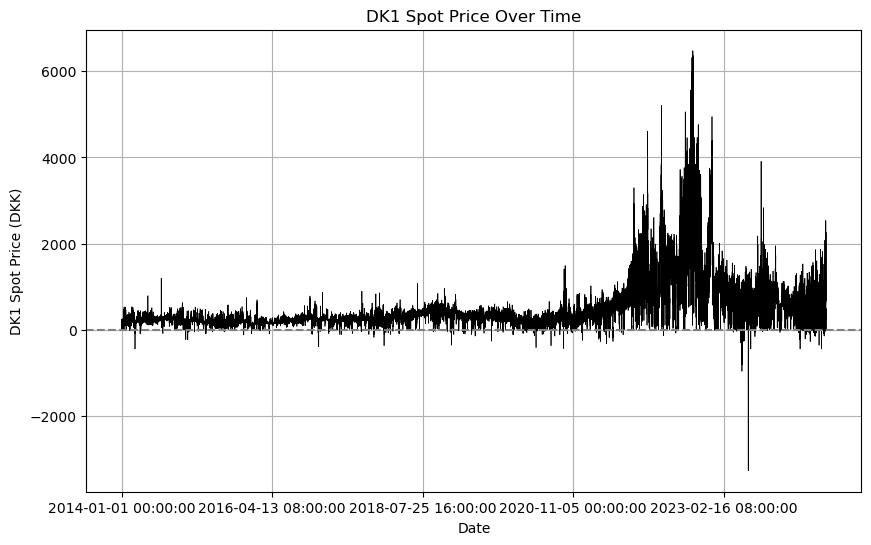

In [4]:
import matplotlib.pyplot as plt

filtered_df = merged_df[merged_df.index >= '2008-01-01']

# Plot DK1_spot with black color, smaller line thickness, and x-line at y=0
plt.figure(figsize=(10,6))
filtered_df['DK1_spot'].plot(color='black', linewidth=0.5)  # Black line with smaller thickness

plt.axhline(0, color='gray', linestyle='--')  # Add a horizontal line at y=0

plt.title('DK1 Spot Price Over Time')
plt.xlabel('Date')
plt.ylabel('DK1 Spot Price (DKK)')
plt.grid(True)
plt.show()


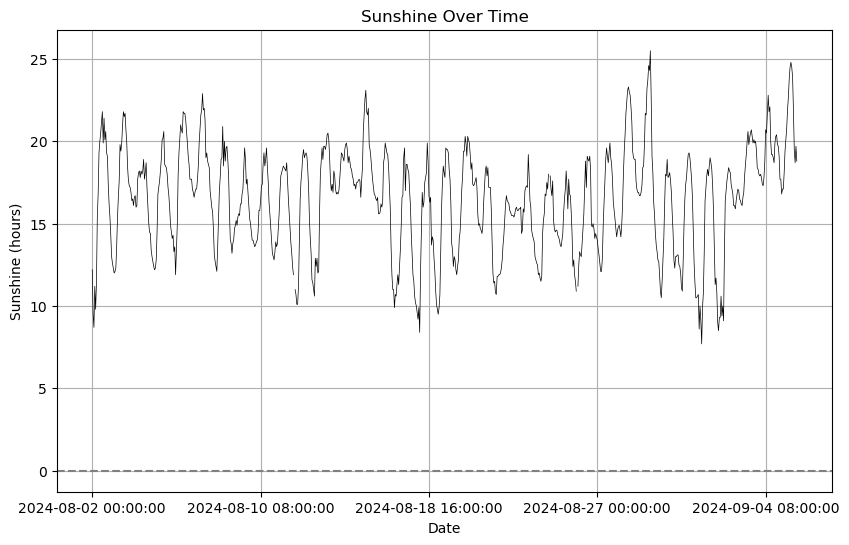

In [5]:
import matplotlib.pyplot as plt

filtered_df = merged_df[merged_df.index >= '2024-08-02']

# Plot DK1_spot with black color, smaller line thickness, and x-line at y=0
plt.figure(figsize=(10,6))
filtered_df['temp_06032'].plot(color='black', linewidth=0.5)  # Black line with smaller thickness

plt.axhline(0, color='gray', linestyle='--')  # Add a horizontal line at y=0

plt.title('Sunshine Over Time')
plt.xlabel('Date')
plt.ylabel('Sunshine (hours)')
plt.grid(True)
plt.show()
